In [1]:
%matplotlib widget


# Fitting configuration

For each line fitting, $LiMe$ provides two kind of measurements. Those based on the [integration  of the flux](https://lime-stable.readthedocs.io/en/latest/outputs/outputs1_measurements.html#integrated-properties) within the line band and those which assume a shape for the line profile. By default, $LiMe$ assumes a single Gaussian profile, which is parametrised by the following formula:

$F_{\lambda}=\sum_{i}A_{i}e^{-\left(\frac{\lambda-\mu_{i}}{2\sigma_{i}}\right)^{2}} + c_{\lambda}$


where, one the left-hand side $F_{\lambda}$ is the line flux. On the right-hand side, we have two components: The first one is the Gaussian profile,  where $A_{i}$ is the height of a Gaussian profile above the continuum level, $\mu_{i}$ is the center of the of Gaussian profile and $\sigma_{i}$ is its standard deviation. The second component is the linear continuum of the line $c_{\lambda}$. $LiMe$ computes this continuum from the adjacent bands assuming a linear relation and by default it is kept constanst during the fitting.

<div class="alert alert-info">

**Please remember:** By default $LiMe$ assumes a single Gaussian profile in the line measurements. To fit anything more complex, the [line label](https://lime-stable.readthedocs.io/en/latest/inputs/n_inputs2_line_labels.html#Modularity-component) must have the blended suffix **(_b)** and **line components** specified in the profile configuration.
</div>

To show some examples regarding the fitting configuration notation, we are going to use some data from the [3rd tutorial](hhttps://lime-stable.readthedocs.io/en/latest/tutorials/n_tutorial3_complete_spectrum.html). This tutorial can be found as a notebook in the Github [examples/inputs](https://github.com/Vital-Fernandez/lime/tree/master/examples/inputs) folder.

## Configuration files

Let's start by loading the libraries to run the samples:

In [2]:
from IPython.display import Image, display
from pathlib import Path
import lime

lime.theme.set_style(fig_conf={"figure.dpi": 100})

Now we proceed to declare the data location:

In [3]:
# State the data files
obsFitsFile = '../sample_data/spectra/gp121903_osiris.fits'
lineBandsFile = '../sample_data//osiris_bands.txt'
cfgFile = '../sample_data/osiris.toml'

In the recomended workflow, you should use an external text file to define the configuration of your fittings. This file must use the [toml](https://toml.io/en/) configuration format. The image below shows part of the ``osiris.toml`` file in the [examples/inputs](https://github.com/Vital-Fernandez/lime/tree/master/examples/inputs) folder:

<img src='../images/conf_file_osiris.png' width="1200" />

These configuration files consit in one or more sections, enclosed by squared brackets (**[section_name]**) with several properties/keys equal to their assigned value (**property = value**). The user is encouraged to read the [toml](https://toml.io/en/v1.0.0) examples to take full advantage on how to store variables on a text file. However, it is important to keep in mind the following constrains: 

* String properties must be surrounded by single ('my string') or double ("my string") quotation marks.
* By default Section and property names can only have ASCII letters, ASCII digits, underscores, and dashes. If you want to use additional character you need to declare them as strings (using single or double quotation marks). For example you can define lines with decimal places using:
* Section and property names should not use dots. In configuration files dots are used to declare key-value substructures. If you section or property label needs them you can use using single or double quotation marks.

For example, if you want to specify the decimal places in the unit labels you should use quotation marks:

```O3_5007A_b = "O3_5007.89A+O3_5007.89A_k-1"```

or

```"O3_5007.89_b" = "O3_5007.89A+O3_5007.89A_k-1"```

You can use the [``lime.load_cfg``](https://lime-stable.readthedocs.io/en/latest/introduction/api.html#lime.load_cfg) function to load a [.toml](https://toml.io/en/) file as a dictionary of dictionaries:

In [4]:
# Load configuration
obs_cfg = lime.load_cfg(cfgFile)
print('osiris configuration')
obs_cfg

osiris configuration


{'sample_data': {'files_list': ['gp030321_BR.fits',
   'gp101157_BR.fits',
   'gp121903_BR.fits'],
  'object_list': ['gp030321', 'gp101157', 'gp121903'],
  'z_array': [0.16465, 0.14334, 0.19531],
  'zErr_array': [7.389e-05, 0.000129, 0.0001403],
  'norm_flux': 1e-17},
 'default_line_fitting': {'O2_3726A_m': 'O2_3726A+O2_3729A',
  'H1_3889A_m': 'H1_3889A+He1_3889A',
  'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
  'O2_7319A_m': 'O2_7319A+O2_7330A'},
 'gp121903_line_fitting': {'O1_6300A_b': 'O1_6300A+S3_6312A',
  'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
  'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp', 'min': 0.0},
  'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
  'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
  'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
  'N2_6548A_kinem': 'N2_6584A',
  'S2_6716A_b': 'S2_6716A+S2_6731A',
  'S2_6731A_kinem': 'S2_6716A'}}

<div class="alert alert-info">

**Please remember:** If one of the sections in your configuration file has the **_line_fitting** suffix, $LiMe$ transforms the keys:

   ``N2_6548A_amp = "expr:N2_6584A_amp/2.94"``
   
   ``O3_5007A_k-1_amp = "expr:<100.0*O3_5007A_amp,min:0"``
    
is converted into a dictionary:
    
   ``N2_6548A_amp : {'expr': 'N2_6584A_amp/2.94'}``
   
   ``O3_5007A_k-1_amp : {"expr":"<100.0*O3_5007A_amp","min":0}``

The user is encourge to use **_line_fitting** suffix in sections with data for $LiMe$ fittings. This will make sure the inputs are formatted to the expected format.    
</div>

Beyond $LiMe$ fitting parameters you can store any kind of information on this file:

In [5]:
z_obj = obs_cfg['sample_data']['z_array'][2]
norm_flux = obs_cfg['sample_data']['norm_flux']

Now, we can define our spectrum:

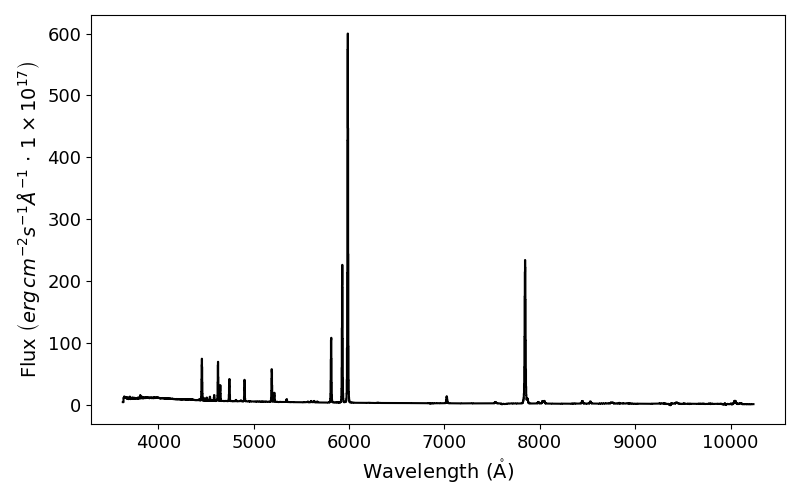

In [6]:
# Declare LiMe spectrum
gp_spec = lime.Spectrum.from_file(obsFitsFile, instrument='osiris', redshift=z_obj, norm_flux=norm_flux)
gp_spec.plot.spectrum()

## Configuration file sections

We can see in the configuration file that ``["default_line_fitting"]`` section has some merged lines while the ``["gp121903_line_fitting"]`` section has the blended lines configuration data:

In [7]:
# Some lines with the multiple components:
print(obs_cfg['default_line_fitting']['H1_3889A_m'])
print(obs_cfg['gp121903_line_fitting']['S2_6716A_b'])

H1_3889A+He1_3889A
S2_6716A+S2_6731A


$LiMe$ ``.fit`` functions can read the bands and configuration files directly:

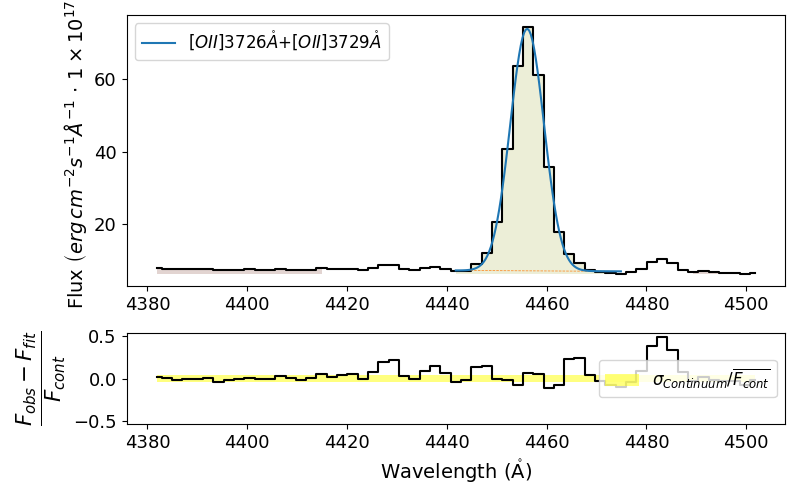

In [8]:
# Fit and plot of a blended line with two components
gp_spec.fit.bands('O2_3726A_m', lineBandsFile, cfgFile)
gp_spec.plot.bands('O2_3726A_m')

The ``default_conf_prefix='default'`` argument in the ``.fit`` functions states the default configuration header. If we try to fit a blended line, $LiMe$ won't be able to find the correct configuration with these settings: 

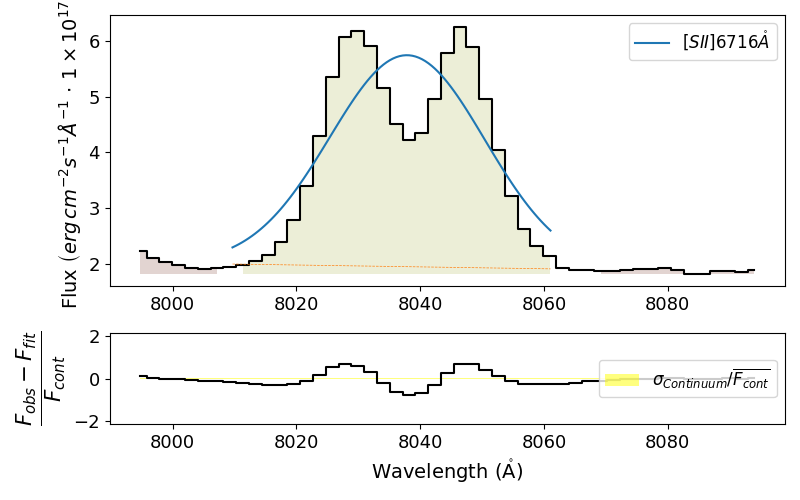

In [9]:
# Fit and plot of a blended line with two components
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.bands('S2_6716A_b', lineBandsFile, cfgFile)
gp_spec.plot.bands()

However, if we change the section name for this parameter, $LiMe$ will find the line configuration and the two components will be fitted:

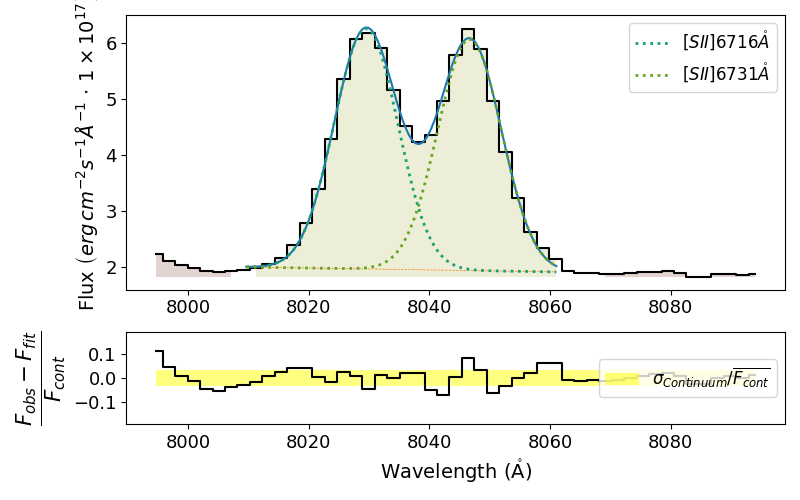

In [10]:
# Fit and plot of a blended line with two components
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.bands('S2_6716A_b', lineBandsFile, cfgFile, default_conf_prefix='gp121903')
gp_spec.plot.bands()

You can combine both the default and custom object configuration if you introduce the name of the section corresponding to current fitting in the ``id_conf_prefix`` argument:


Line fitting progress:
[==========] 100% of 34 lines (Ar3_7751A))

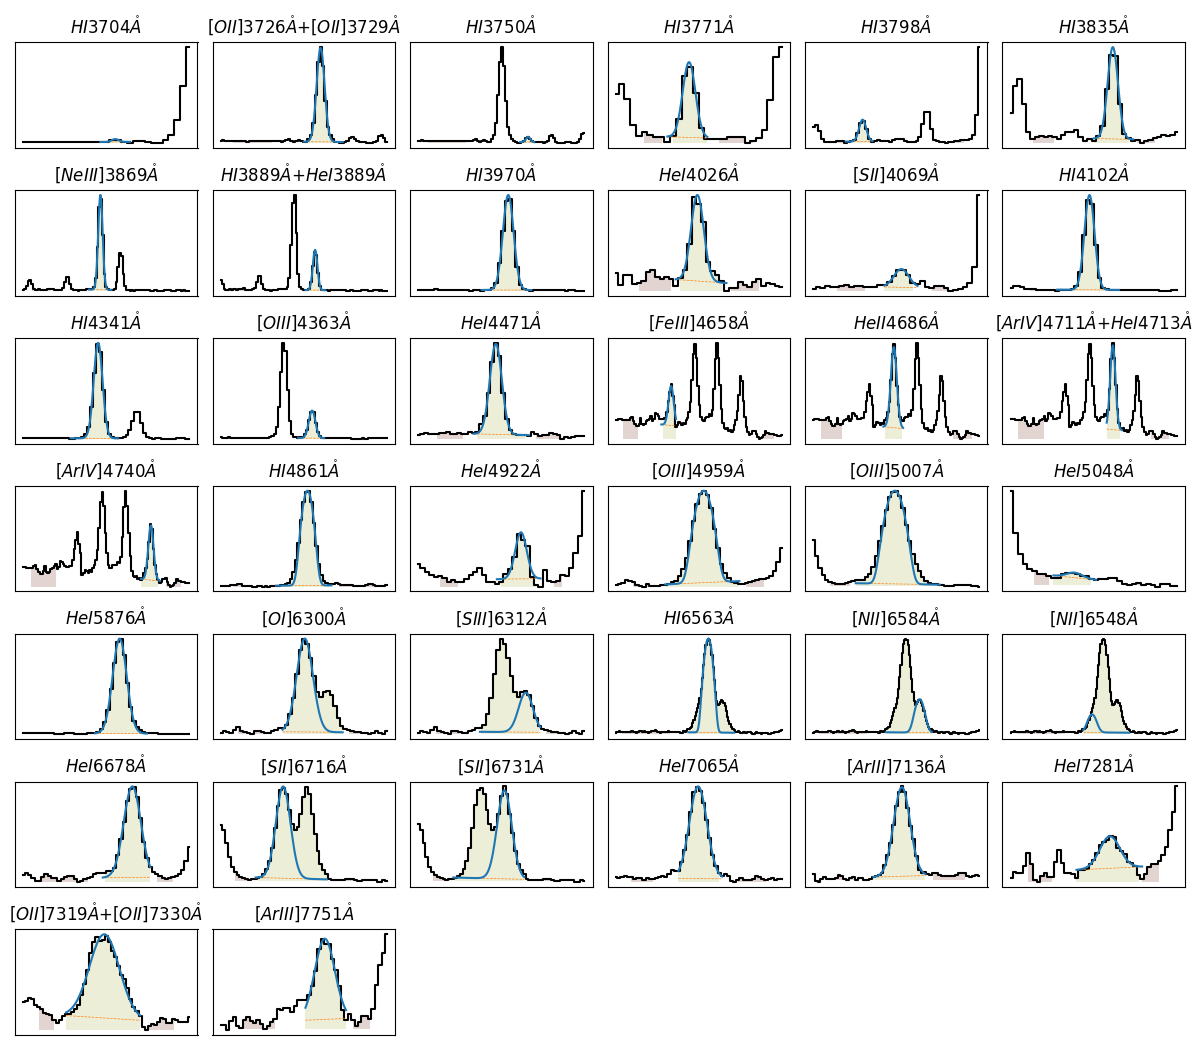

In [11]:
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.frame(lineBandsFile, cfgFile, id_conf_prefix='gp121903')
gp_spec.plot.grid()

In this case, we $LiMe$ updated the ``["default_line_fitting"]`` line fitting configuration with the ``["gp121903_line_fitting"]`` so we are fitting both the merged and blended lines. 

<div class="alert alert-info">

**Please remember:** If both the ``["default_line_fitting"]`` and ``["gp121903_line_fitting"]`` have the entries with the same keys, the custom ``id_conf_prefix`` (in this case ``["gp121903_line_fitting"]``) will overwrite the default configuration (in this case ``["default_line_fitting"]``).
</div>

## Model parameters:

$LiMe$ fits the theoretical profile using [LmFIT](https://lmfit.github.io/lmfit-py/). For each line we define 3 [parameters](https://lmfit.github.io/lmfit-py/parameters.html) per component in the equation above plus 2 more for the local continuum. These are labeled using the line name and the following suffixes:

* **_amp**: the height of the Gaussian from the continuum. An initial value must be normalized by the ``lime.Spectrum.norm_flux``. 
* **_center**: the wavelength of the Gaussian peak in the spectrum wavelength units. The initial value will be multiplied by $(1 + z)$.
* **_sigma**: the width of the Gaussian curve in the spectrum wavelength units.
* **_cont_slope**: the local continuum gradient. In blended lines, there is only one continuum labeled after the first component.
* **_cont_intercept**: the linear flux at zero wavelength for the local continuum. In blended lines there is still only one continuum intercept labeled after the first component.


<div class="alert alert-info">

**Please remember:** It should be explained that we are not using the default [Gaussian model](https://lmfit.github.io/lmfit-py/builtin_models.html#lmfit.models.GaussianModel) in LmFit:
   Their in-built model defines the amplitude $A_{i}$ as the area under the Gaussian profile. While this notation
   provides a cleaner mathematical description, in the fitting of astronomical spectra it is seldom easy to constrain
   the flux in advance. Instead, we define the amplitude as the height of the Gaussian.
</div>

In your configuration file, you can adjust the fitting for each of these parameters with the by adding line label followed by the corresponding suffix. For example, in the $[NII]6548Å$ we constrained its amplitude:
```
H1_6563A_b = "H1_6563A+N2_6584A+N2_6548A"
N2_6548A_amp = "expr:N2_6584A_amp/2.94"
N2_6548A_kinem = "N2_6584A"
```

There are five attributes you can use to adjust the fitting on the [parameters](https://lmfit.github.io/lmfit-py/parameters.html):

* ``value``: Initial value for the parameter. $LiMe$ provides an initial guess for the parameters from
  the [integrated measurements](https://lime-stable.readthedocs.io/en/latest/documentation/measurements.html#integrated-properties).
* ``vary``: Whether the parameter is free during the fitting (default is True). If set to *False* the initial ``value`` will remain unchanged.
* ``min``: Lower bound for the parameter value. The default is value is -numpy.inf (no lower bound).
* ``max``: Upper bound for the parameter value. The default is value is numpy.inf (no upper bound).
* ``expr``: Mathematical expression to constrain the value during the fit. The default value is None.

<div class="alert alert-info">

**Please remember:** In the configuration file, the line parameters attributes are comma **(,)** separated and the key-value entries are separated by a colon **(:)**.
</div>

The ``expr`` argument can be used to link the parameters with each other (as long as these profiles are fitted simultaneously). For example, in the case above we are tiding the $[NII]6548Å$ amplitude to the one of $[NII]6584Å$ given theoretical emissivity relation between these transitions (2.94, which is constant independently of the physical conditions):

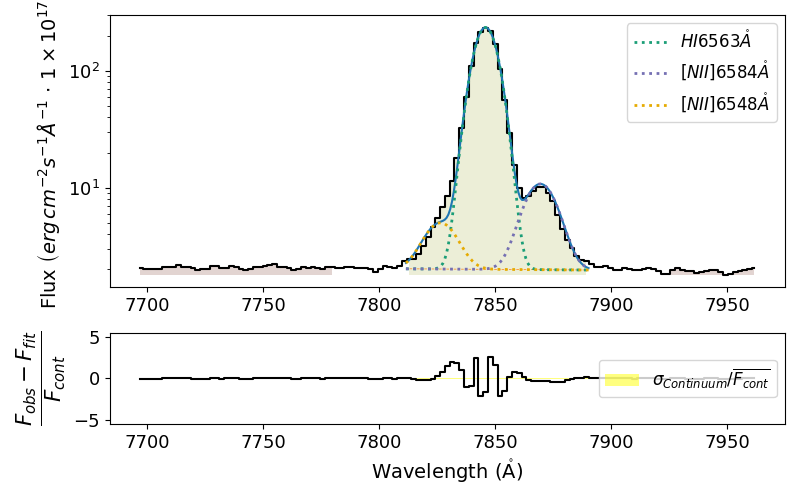

In [12]:
# Fit and plot of a line with a parameter using the "expr" :
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.bands('H1_6563A_b', lineBandsFile, cfgFile, id_conf_prefix='gp121903')
gp_spec.plot.bands('H1_6563A')

This is a convenient way to tie the flux between lines in the same blended groups. As you can see from the plot above the Gaussin flux ratio between both transitions is very close to the theoretical ratio. This can also be concluded from the measurements log:

In [13]:
N2_flux_ratio = gp_spec.frame.loc["N2_6584A", "profile_flux"]/gp_spec.frame.loc["N2_6548A", "profile_flux"]
print(f'[NII] doublet gaussian flux ratio: {N2_flux_ratio:0.3f}')

[NII] doublet gaussian flux ratio: 2.954


## Inequality boundary conditions:

$LiMe$ includes the posibility to add inequalities in [LmFIT](https://lmfit.github.io/lmfit-py/) ``expr`` argument. For example, to fit the wide component for $[OIII]5007Å$ we have the following configuration:
```
O3_5007A_b = 'O3_5007A+O3_5007A_k-1'
O3_5007A_k-1_amp = "expr:<100.0*O3_5007A_amp,min:0"
O3_5007A_k-1_sigma = "expr:>2.0*O3_5007A_sigma"
```

These commands **force the wide component to have a velocity dispersion twice the value of the narrow component**, while its amplitude must be **100 times smaller but still above 0**.

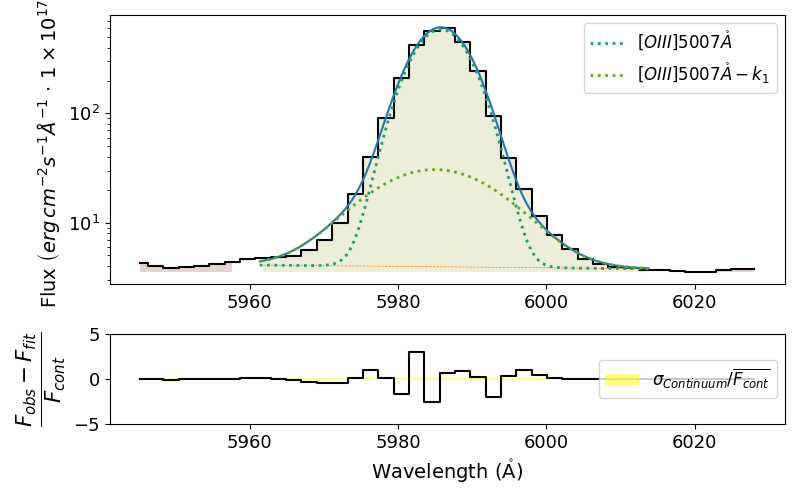

In [14]:
gp_spec.fit.bands('O3_5007A_b', lineBandsFile, cfgFile, id_conf_prefix='gp121903')
gp_spec.plot.bands('O3_5007A')

It is important for the user to realize that it is essential to include these contrains for the fitting of multiple kinematic components even if the instrument resolution is high enough. This is because the algorithm may interchange the fitting label (k-0, k-1,...) from one line to another if the user does not provide any indication.

<div class="alert alert-info">

**Please remember:** In the current release only multiplication can be used along the inequality term. Please contact the author if you have any issue/request with this functionality.

</div>

## Importing external line kinematics:

While the amplitude of an emission profile is dominated by the emissivity of the corresponding transition and the gas physical conditions; its width is mostly dependant on the gas kinematics. Moreover, discrepancies with the theoretical wavelength are also due to the gas kinematics.

Consequently, in some cases it is useful to constrain the line velocity dispersion $(\sigma)$ and radial velocity in the line of sight $(v_{r})$ from the measurements of another line. For example:

$\sigma_{A} = \sigma_{B}$

$v_{r,\,A} = v_{r,\,B}$

where *A* and *B* are two different transtions and both $v_{r}$ and $\sigma$ are in velocity units (for example $km/s$). To convert the equations above to the spectrum wavelength units, we use:

$\sigma_{A} = \sigma_{B}\cdot\frac{\lambda_{A}}{\lambda_{B}}\left(\text{Å}\right)$

$\mu_{A} = \mu_{B}\cdot\frac{\lambda_{A}}{\lambda_{B}}\left(\text{Å}\right)$



where $\mu$ and $\lambda$ are observed and theoretical transition wavelength respectively. The second term takes into consideration the object redshift.



In the configuration file, these two constrains can be set simultaneously with the **_kinem** suffix on the line importing the kinematics. For example, in the fitting of $H\alpha$ and the $[NII]6548,6584Å$ doublet we had:

```
H1_6563A_b = "H1_6563A+N2_6584A+N2_6548A"
N2_6548A_amp = "expr:N2_6584A_amp/2.94"
N2_6548A_kinem = "N2_6584A"
```
Resulting in:

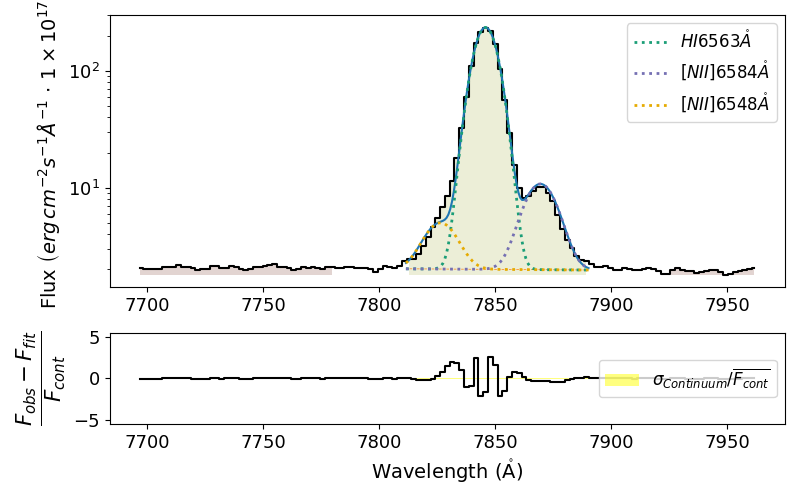

In [15]:
# Fit and plot of a line with a parameter using the "expr" :
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.bands('H1_6563A_b', lineBandsFile, cfgFile, id_conf_prefix='gp121903')
gp_spec.plot.bands('H1_6563A')

In this case, the kinematics of $[NII]6548,6584Å$ lines are tied together together during the fitting. However, we can also use this line to import the kinematics from a line measured previously. For example, we can measure $H\beta$:

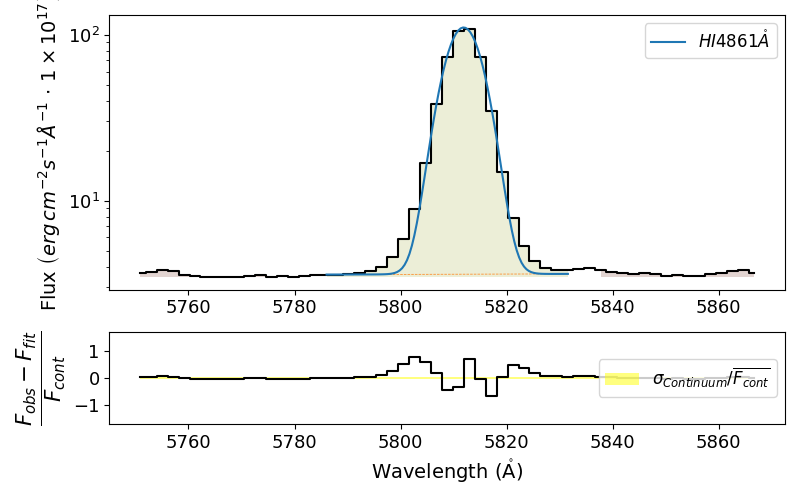

In [16]:
gp_spec.frame.drop(gp_spec.frame.index, inplace=True) # Reset measurements data
gp_spec.fit.bands('H1_4861A', lineBandsFile, cfgFile, id_conf_prefix='gp121903')
gp_spec.plot.bands()

And repeat the fitting imposing this line kinematics on the three transition:

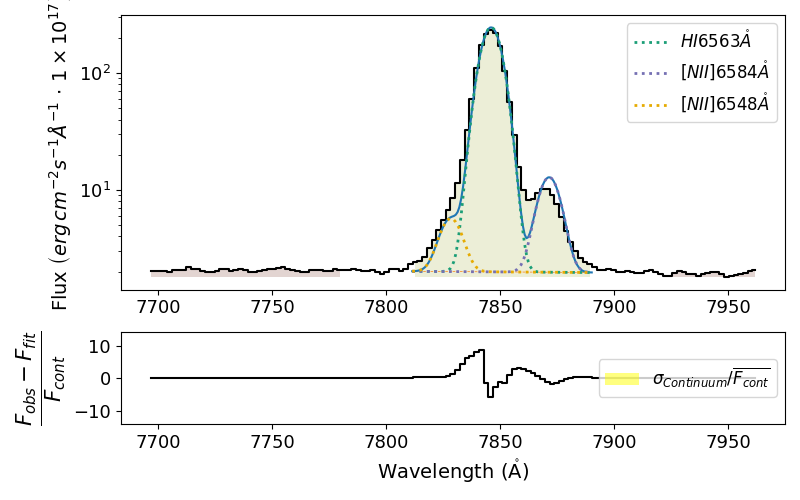

In [17]:
# Fit of a line importing the kinematics from an external line
Halpha_cfg = {'H1_6563A_b'      : 'H1_6563A+N2_6584A+N2_6548A',
              'H1_6563A_kinem'  : "H1_4861A",
              'N2_6584A_kinem'  : "H1_4861A",
              'N2_6548A_kinem'  : "H1_4861A",
              'N2_6548A_amp'    : {'expr': 'N2_6584A_amp/2.94'},
             }
gp_spec.fit.bands('H1_6563A_b', lineBandsFile, Halpha_cfg)
gp_spec.plot.bands('H1_6563A')

From these results, you can see that the kinematics of $H\beta$ fit reasonable well in the $H\alpha$ aline. However, there are issues for the $[NII]$ doublet. This is due to the wide component of $H\alpha$.